In [1]:
import polars as pl
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

from rs_graph.sources.softcite_2025 import SOFTCITE_ANNOTATED_PATH

annotated = pl.read_csv(SOFTCITE_ANNOTATED_PATH)
annotated = annotated.drop_nulls(subset=["label"])
purpose_assessments = pl.read_parquet(
    "~/Downloads/softcite-extractions-oa-data/p05_five_percent_random_subset/purpose_assessments.pdf.parquet"
)

In [2]:
purpose_with_label = (
    purpose_assessments.with_columns(
        pl.col("software_mention_id").str.strip_chars().alias("software_mention_id"),
    )
    .filter(
        pl.col("scope") == "document",
        pl.col("software_mention_id").is_in(annotated["software_mention_id"].to_list()),
    )
    .join(
        annotated.select(
            "software_mention_id",
            "label",
        ),
        on="software_mention_id",
        how="left",
    )
    .select(
        "software_mention_id",
        "label",
        "purpose",
        "certainty_score",
    )
    .filter(pl.col("label").is_in(["yes", "no"]))
    .pivot(
        on="purpose",
        values="certainty_score",
        index=["software_mention_id", "label"],
    )
)

purpose_with_label

software_mention_id,label,created,shared,used
str,str,f64,f64,f64
"""124473.pdf.00020""","""yes""",0.999936,0.993968,0.999996
"""241501.pdf.00047""","""yes""",0.999401,0.988754,0.999674
"""306099.pdf.00049""","""yes""",0.999588,0.962104,0.996425
"""345771.pdf.00001""","""yes""",0.000323,0.98124,0.003668
"""361382.pdf.00047""","""yes""",0.013075,0.983392,0.120797
…,…,…,…,…
"""23403915.pdf.00122""","""yes""",0.20299,0.984028,0.989919
"""23495598.pdf.00037""","""yes""",0.999865,0.992281,0.999996
"""23615118.pdf.00014""","""yes""",0.000015,0.977074,0.000432


              precision    recall  f1-score   support

         yes       0.27      0.83      0.40        36
          no       0.82      0.25      0.38       110

    accuracy                           0.39       146
   macro avg       0.54      0.54      0.39       146
weighted avg       0.68      0.39      0.38       146



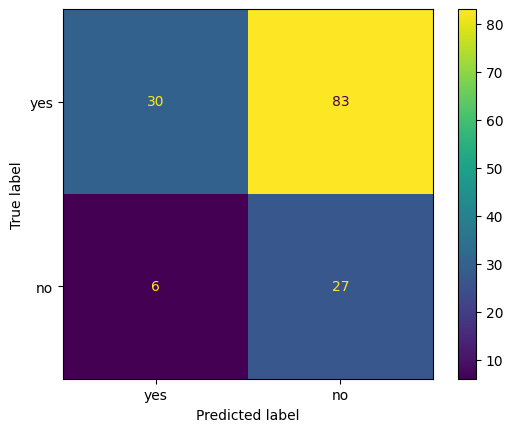

In [3]:
heuristic_approach = purpose_with_label.with_columns(
    pl.when(pl.col("created") > 0.98)
    .then(pl.lit("yes"))
    .otherwise(pl.lit("no"))
    .alias("predicted_label")
)

print(
    classification_report(
        y_true=heuristic_approach["predicted_label"].to_list(),
        y_pred=heuristic_approach["label"].to_list(),
        labels=["yes", "no"],
    )
)

ConfusionMatrixDisplay.from_predictions(
    y_true=heuristic_approach["label"].to_list(),
    y_pred=heuristic_approach["predicted_label"].to_list(),
    labels=["yes", "no"],
)

In [4]:
heuristic_approach.filter(
    pl.col("predicted_label") == "no",
    pl.col("label") == "yes",
).select(
    "created",
    "shared",
    "used",
).describe()

statistic,created,shared,used
str,f64,f64,f64
"""count""",83.0,83.0,83.0
"""null_count""",0.0,0.0,0.0
"""mean""",0.092802,0.885291,0.394784
"""std""",0.24227,0.233536,0.448129
"""min""",0.000009,3.5763e-7,0.000052
"""25%""",0.000081,0.920741,0.002286
"""50%""",0.000336,0.977472,0.090296
"""75%""",0.009785,0.991079,0.989919
"""max""",0.962179,0.996246,0.999995


              precision    recall  f1-score   support

         yes       0.93      0.61      0.74        23
          no       0.40      0.86      0.55         7

    accuracy                           0.67        30
   macro avg       0.67      0.73      0.64        30
weighted avg       0.81      0.67      0.69        30



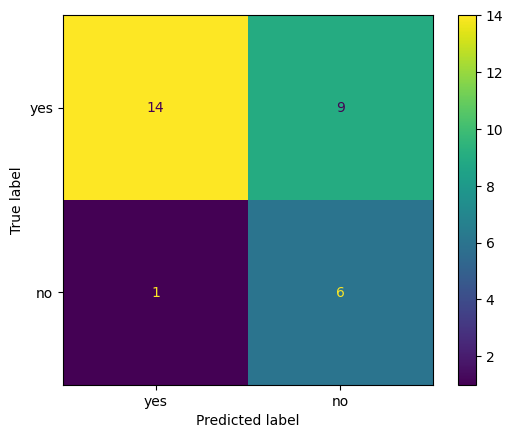

In [5]:
# Train logit from sklearn for best
modeling_approach = purpose_with_label.with_columns(
    (pl.col("used") * pl.col("shared")).alias("used_shared"),
    (pl.col("created") * pl.col("shared")).alias("created_shared"),
    (pl.col("used") * pl.col("created")).alias("used_created"),
)

# Create splits
train_set, test_set = train_test_split(
    modeling_approach.to_pandas(),
    test_size=0.2,
    random_state=12,
    stratify=modeling_approach["label"].to_list(),
)

cols_for_modeling = [
    "shared",
    "created",
    "used",
    "used_shared",
    "created_shared",
    "used_created",
]

logit = LogisticRegressionCV(
    max_iter=1000,
    random_state=12,
    class_weight="balanced",
).fit(
    train_set[[*cols_for_modeling]],
    train_set["label"].to_list(),
)

preds = logit.predict(test_set[[*cols_for_modeling]])

print(
    classification_report(
        y_true=test_set["label"],
        y_pred=preds,
        labels=["yes", "no"],
    )
)

ConfusionMatrixDisplay.from_predictions(
    y_true=test_set["label"],
    y_pred=preds,
    labels=["yes", "no"],
)

In [6]:
for feature_name, coef in zip(cols_for_modeling, logit.coef_[0], strict=False):
    print(f"{feature_name}: {coef:.4f}")

shared: 0.9373
created: 0.3207
used: -0.1118
used_shared: -0.5715
created_shared: 0.4333
used_created: 0.3629
